# Define parameters

In [4]:
import subprocess
import sys
import os

is_front_camera_training = False  # Change it to False if training for down cmaera.

In [5]:
################################# OS PARAMETERS ##################################
os_name = os.name
# Windows = nt, [Linux, Apple] = posix. 
os_path = "\\" if os_name == "nt" else "/"  
##################################################################################
############################## ROBOFLOW  PARAMETERS ##############################
roboflow_api_key = "MJQUATZvpcKoBxRjLuXx"
roboflow_workspace_name = "auv2024"
dataset_export_format = "yolov8"
if is_front_camera_training:
     roboflow_project_name = "down-camera-comp"
else:
     roboflow_project_name = "down-camera-sim"
##################################################################################
############################## TRAINING  PARAMETERS ##############################
if is_front_camera_training:
     target_classes = ["bouy", "gate", "octagon-table"]
     model_save_filename = "best_AUV_sim_front_camera_model.pt"
else: 
     target_classes = ["bin", "lane-marker", "octagon-table"]
     model_save_filename = "best_AUV_sim_down_camera_model.pt"
model_name = "yolov8n.pt"
train_test_val_split = (0.7, 0.2, 0.1)
epoch_increments = 200
batch_size = -1 # Auto Mode (60% GPU Memory): Use batch=-1 to automatically 
                # adjust batch size for approximately 60% CUDA memory 
                # utilization.
workers = 2
cache = False
pretrained = True
imgsz = [480, 640]
hsv_h = 0.015
hsv_s = 0.3
hsv_v = 0.3
translate = 0.0
scale = 0.0
fliplr = 0.5
flipud = 0.5
mosaic = 0.1
copy_paste = 0.0
erasing = 0.0
crop_fraction = 0.1
degrees = 180
##################################################################################
######################### CUSTOM AUGMENTATION PARAMETERS #########################
colorAugmentProb = 0.5
noiseAugmentProb = 0.5
resolutionAugmentProb = 0.0
contrastAugmentProb = 0.5
blurAugmentProb = 0.5
brightnessAugmentProb = 0.5
##################################################################################

# Implementation

## Setup python dependencies 

In [6]:
packages = [
     "roboflow", 
     "albumentations", 
     "opencv-python", 
     "ultralytics",
     "pandas"
]

try:
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("Packages installed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 26.2 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Packages installed successfully.


In [23]:
import shutil
import cv2
import albumentations as A
import copy
import random
import numpy as np
from ultralytics import YOLO
import torch
from roboflow import Roboflow
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
!mkdir data
!mkdir data/augmented
!mkdir data/augmented/images
!mkdir data/augmented/labels
!mkdir data/augmented/train
!mkdir data/augmented/test
!mkdir data/augmented/val
!mkdir data/augmented/train/images
!mkdir data/augmented/test/images
!mkdir data/augmented/val/images
!mkdir data/augmented/train/labels
!mkdir data/augmented/test/labels
!mkdir data/augmented/val/labels
!mkdir data/raw
!mkdir data/raw/images
!mkdir data/raw/labels

mkdir: data: File exists
mkdir: data/augmented: File exists
mkdir: data/augmented/train: File exists
mkdir: data/augmented/test: File exists
mkdir: data/augmented/val: File exists
mkdir: data/augmented/train/images: File exists
mkdir: data/augmented/test/images: File exists
mkdir: data/augmented/val/images: File exists
mkdir: data/augmented/train/labels: File exists
mkdir: data/augmented/test/labels: File exists
mkdir: data/augmented/val/labels: File exists


## Define YOLO classes

In [10]:
data_folder_absolute_path = os.path.abspath("data")
print(f"Data absolute path: {data_folder_absolute_path}.")

with open("data.yaml", "w+") as f:
    f.write(f"train: {data_folder_absolute_path}{os_path}augmented{os_path}train{os_path}images\n")
    f.write(f"test: {data_folder_absolute_path}{os_path}augmented{os_path}test{os_path}images\n")
    f.write(f"val: {data_folder_absolute_path}{os_path}augmented{os_path}val{os_path}images\n")
    f.write(f"nc: {len(target_classes)}\n")
    f.write(f"names: {target_classes}")

Data absolute path: /Users/owenlesann/robotics/AUV-2025/catkin_ws/src/vision/model_pipeline/data.


## Define augmentation functions

In [11]:
# Given a list of samples, make two copies of each sample that are darker/brighter to simulate differently lit environments.
def brightnessAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.ColorJitter(brightness=(1.5, 1.5), contrast=0, saturation=0, hue=0, always_apply=True)])
        bright_img = transform(image=image)["image"]
        transform = A.Compose([A.ColorJitter(brightness=(0.5, 0.5), contrast=0, saturation=0, hue=0, always_apply=True)])
        dark_img = transform(image=image)["image"]
        out.append(bright_img)
        out.append(dark_img)
    return out

# Given a list of samples, make a copy of each sample but more blurred to simulate objects out of focus, dirty lenses, and backscattering.
def blurAugment(images):
    out = []
    for image in images:
        ksize = (8, 8) # lower to lower blur
        blurred_img = cv2.blur(image, ksize)
        out.append(blurred_img)
    return out

# Given a list of samples, make a copy of each sample but with a lower contrast image to simulate backscattering and over/under-exposure.
def contrastAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.ColorJitter (brightness=0, contrast=(0.5, 0.5), saturation=0, hue=0, always_apply=True)])
        decontrasted_img = transform(image=image)["image"]
        out.append(decontrasted_img)
    return out

# Given a list of samples, make a copy of each sample but with camera noise added to the image to simulate different camera feeds.
def noiseAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.ISONoise(color_shift=(0.1, 0.1), intensity=(0.5, 0.5), always_apply=True)])
        noisy_img = transform(image=image)["image"]
        out.append(noisy_img)
    return out

# Given a list of samples, make a copy of each sample but with the image downscaled (lower resolution of image) to simulate lower quality cameras/images.
def resolutionAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.Downscale(scale_min=0.2, scale_max=0.2, always_apply=True)])
        low_res_img = transform(image=image)["image"]
        out.append(low_res_img)
    return out

# Increase intensity of blues in given image.
def make_bluer(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) # Split by channel.
    img_b = np.uint16(img_b)
    img_b += color_shift_intensity
    np.clip(img_b, 0, 255, out=img_b)
    img_b = np.uint8(img_b)
    img = cv2.merge((img_b, img_g, img_r)) # Merge adjusted channels.
    del img_b
    del img_g
    del img_r
    return img

# Increase intensity of greens in given image.
def make_greener(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) # Split by channel.
    img_g = np.uint16(img_g)
    img_g += color_shift_intensity
    np.clip(img_g, 0, 255, out=img_g)
    img_g = np.uint8(img_g)
    img = cv2.merge((img_b, img_g, img_r)) # Merge adjusted channels.
    del img_b
    del img_g
    del img_r
    return img

# Given a list of samples, make two copies of each sample (one bluer, one greener) to simulate different pools + color attenuation.
def colorAugment(images):
    out = []
    color_shift_intensity = int(255*0.05)
    for image in images:
        blue_img = make_bluer(image, color_shift_intensity)
        green_img = make_greener(image, color_shift_intensity)
        out.append(blue_img)
        out.append(green_img)
    return out

# Given a single image and augmentation function, displays the image before and images after augmentation.
def visualizeAugmentation(img, aug):
    # Show original image.
    cv2.imshow("og", img)
    cv2.waitKey(0)
    # Show all augmented images.
    for augmented in aug([(img, "")])[1:]:
        cv2.imshow("augmented", augmented[0])
        cv2.waitKey(0)

In [12]:
def get_file_names(source_folder):
    label_filenames = []
    img_filenames = [f for f in os.listdir(source_folder + f"{os_path}images") if os.path.isfile(os.path.join(source_folder + f"{os_path}images", f))]
    for img_filename in img_filenames:
        label_filenames.append(os.path.splitext(img_filename)[0] + ".txt")

    return np.array(img_filenames), np.array(label_filenames)

def split_and_move_data(source_dir, dest_dir, split_ratio=(0.7, 0.2, 0.1)):
    source_image_dir = f"{source_dir}{os_path}images"
    source_label_dir = f"{source_dir}{os_path}labels"
    # Get list of image and label files.
    image_files = sorted(os.listdir(source_image_dir))
    label_files = sorted(os.listdir(source_label_dir))

    # Shuffle the indices.
    indices = np.arange(len(image_files))
    np.random.shuffle(indices)
    
    # Calculate split indices.
    total_count = len(image_files)
    train_end = int(total_count * split_ratio[0])
    val_end = train_end + int(total_count * split_ratio[1])

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Function to move files
    def move_files(indices, split):
        for i in indices:
            shutil.move(os.path.join(source_image_dir, image_files[i]), 
                        os.path.join(dest_dir, split, 'images', image_files[i]))
            shutil.move(os.path.join(source_label_dir, label_files[i]), 
                        os.path.join(dest_dir, split, 'labels', label_files[i]))

    # Move files to corresponding folders
    move_files(train_indices, 'train')
    move_files(val_indices, 'val')
    move_files(test_indices, 'test')

def get_augs(img_filename, source_folder):
    img = cv2.imread(source_folder + f"{os_path}images{os_path}" + img_filename)
    augs = [img]
    if(np.random.rand() < colorAugmentProb):
        augs = augs + colorAugment(augs)
    if(np.random.rand() < noiseAugmentProb):
        augs = augs + noiseAugment(augs)
    if(np.random.rand() < resolutionAugmentProb):
        augs = augs + resolutionAugment(augs)
    if(np.random.rand() < contrastAugmentProb):
        augs = augs + contrastAugment(augs)
    if(np.random.rand() < blurAugmentProb):
        augs = augs + blurAugment(augs)
    if(np.random.rand() < brightnessAugmentProb):
        augs = augs + brightnessAugment(augs)
    return augs

def do_augs_and_export(img_filenames, label_filenames, source_folder, output_folder):
    name_num = 1
    for (img_filename, label_filename) in zip(img_filenames, label_filenames):
        augs = get_augs(img_filename, source_folder)
        with open(source_folder + f"{os_path}labels{os_path}" + label_filename) as f:
            #build array of bounding boxes (each line its own element)
            bounding_boxes = f.read()
        for aug in augs:
            cv2.imwrite(output_folder + f"{os_path}images{os_path}img" + str(name_num) + ".png", aug)
            with open(output_folder + f"{os_path}labels{os_path}img" + str(name_num) + ".txt", "w+") as f:
                f.write(bounding_boxes)
            name_num+=1

## Download dataset from Roboflow

In [13]:
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace(roboflow_workspace_name).project(roboflow_project_name)
latest_version = int(project.versions()[0].version)
version = project.version(latest_version)
dataset = version.download(dataset_export_format)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to down-camera-sim-8 in yolov8:: 100%|█| 840/840 


In [14]:
folder_name = "{}-{}".format(roboflow_project_name, latest_version)
roboflow_folder_path = os.path.abspath(folder_name)
data_folder_path = os.path.abspath("data")

print(f"Roboflow folder name: {folder_name}.")

def copy_all_files(source, destination):
     try:
          # Ensure destination folder exists.
          os.makedirs(destination, exist_ok=True)
          # Copy all files from source to destination.
          for filename in os.listdir(source):
               source_file = os.path.join(source, filename)
               if os.path.isfile(source_file):
                    destination_file = os.path.join(destination, filename)
                    shutil.move(source_file, destination_file)
     except Exception as e:
          print(f"Error copying files: {e}.")

# Copy files from roboflow to data folder.
for folder in ["train", "valid", "test"]:
     print(f"Moving {folder} folder...")
     copy_all_files(os.path.join(roboflow_folder_path, folder, "images"), 
                    os.path.join(data_folder_path, "raw", "images"))
     copy_all_files(os.path.join(roboflow_folder_path, folder, "labels"), 
                    os.path.join(data_folder_path, "raw", "labels"))
     print(f"Moving {folder} folder completed.")

# Optional: Remove roboflow folder after copying files.
try:
     shutil.rmtree(folder_name)
     print(f"Removed folder: {folder_name}.")
except Exception as e:
     print(f"Error removing folder: {e}.")

Roboflow folder name: down-camera-sim-8.
Moving train folder...
Moving train folder completed.
Moving valid folder...
Moving valid folder completed.
Moving test folder...
Moving test folder completed.
Removed folder: down-camera-sim-8.


## Augment data, split into train/test/val

In [15]:
%%capture
out_folder = f"data{os_path}augmented"
in_folder = f"data{os_path}raw"
train = f"{os_path}train"
val = f"{os_path}val"
test = f"{os_path}test"

raw_image_names, raw_label_names = get_file_names(in_folder)
num_raw_samples = len(raw_image_names)
do_augs_and_export(raw_image_names, raw_label_names, in_folder, out_folder)
split_and_move_data(out_folder, out_folder)

os.rmdir(f"data{os_path}augmented{os_path}images")
os.rmdir(f"data{os_path}augmented{os_path}labels")
shutil.rmtree(in_folder)

KeyboardInterrupt: 

In [17]:
augmented_train_img_names, _ = get_file_names(out_folder + train)
augmented_test_img_names, _ = get_file_names(out_folder + test)
augmented_val_img_names, _ = get_file_names(out_folder + val)

num_augmented_samples = len(augmented_train_img_names) + len(augmented_test_img_names) + len(augmented_val_img_names)

print(f"Augmentation completed: went from {num_raw_samples} samples to {num_augmented_samples} after augmentation.")

Augmentation completed: went from 414 samples to 5525 after augmentation.


# Check CUDA dependencies and start training

In [18]:
if not (torch.cuda.is_available() and torch.cuda.device_count()):
    raise RuntimeError("CUDA is NOT available. Please ensure that your system has a compatible GPU and the necessary drivers are installed.")

RuntimeError: CUDA is NOT available. Please ensure that your system has a compatible GPU and the necessary drivers are installed.

In [19]:
runs_folder = "runs"
detect_folder = "detect"

if os.path.exists(runs_folder):
    shutil.rmtree(runs_folder)

os.makedirs(os.path.join(runs_folder, detect_folder), exist_ok=True)

In [20]:
# callback method tracks losses on the training and validation data after each fit epoch (train + val) to test model convergence and fit

# bounding box loss: This loss component measures how accurately the model predicts the spatial location and size of bounding boxes around detected objects.
# classification loss: This loss component evaluates the model's ability to correctly classify the objects within the predicted bounding boxes.
# objectness (confidence) loss: This loss component assesses the model's confidence that a predicted bounding box actually contains an object, as opposed to being background.

train_box_losses = []
train_cls_losses = []
train_obj_losses = []
val_box_losses = []
val_cls_losses = []
val_obj_losses = []

def on_fit_epoch_end(trainer):
    # get the results.csv data
    results = pd.read_csv(trainer.csv)
    # get the current epoch number from the trainer
    current_epoch = trainer.epoch
    # save epoch's losses
    train_box_losses.append(results['           train/box_loss'].iloc[current_epoch])
    train_cls_losses.append(results['           train/cls_loss'].iloc[current_epoch])
    train_obj_losses.append(results['           train/obj_loss'].iloc[current_epoch])
    val_box_losses.append(results['           val/box_loss'].iloc[current_epoch])
    val_cls_losses.append(results['           val/cls_loss'].iloc[current_epoch])
    val_obj_losses.append(results['           val/obj_loss'].iloc[current_epoch])

    print(f"End of epoch {current_epoch}")

In [21]:
data_yaml_file_absolute_path = os.path.abspath("data.yaml")

model = YOLO(model_name) # load a pretrained model.

# register fit callback
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

# Start the training process.
while True:
    try:
        model.train(
            data=data_yaml_file_absolute_path,
            epochs=epoch_increments,
            imgsz=imgsz,
            batch=batch_size,
            pretrained=pretrained,
            task="detect",
            cache=cache,
            workers=workers,
            hsv_h=hsv_h,
            hsv_s=hsv_s,
            hsv_v=hsv_v,
            translate=translate,
            scale=scale,
            fliplr=fliplr,
            flipud=flipud,
            mosaic=mosaic,
            copy_paste=copy_paste,
            erasing=erasing,
            crop_fraction=crop_fraction,
            degrees=degrees
        )
        shutil.copyfile(f"runs{os_path}detect{os_path}train{os_path}weights{os_path}best.pt", model_save_filename)
    except RuntimeError as e:
        print(f"Caught a RuntimeError: {e}.")
        break  # Break out of the loop if an error occurs to prevent infinite loop.

WARNING ⚠️ 'crop_fraction' is deprecated and will be removed in the future.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/owenlesann/robotics/AUV-2025/catkin_ws/src/vision/model_pipeline/data.yaml, degrees=180, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3, hsv_v=0.3, imgsz=[480, 640], int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.1, multi_scale=False, name=train, nbs=64, nms=Fa

KeyboardInterrupt: 

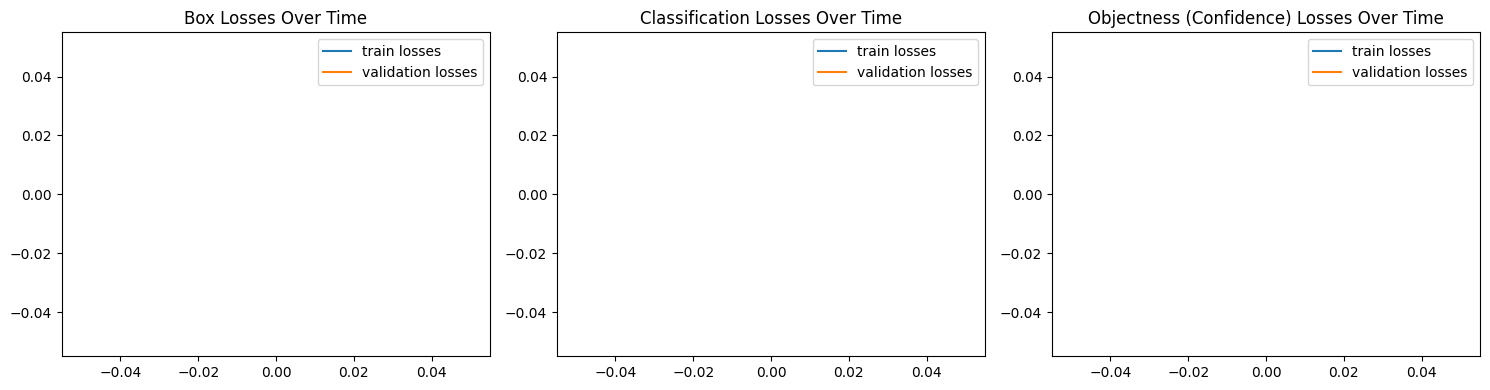

In [26]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Box losses
axes[0].plot(train_box_losses, label="train losses")
axes[0].plot(val_box_losses, label="validation losses")
axes[0].set_title("Box Losses Over Time")
axes[0].legend()

# Classification losses
axes[1].plot(train_cls_losses, label="train losses")
axes[1].plot(val_cls_losses, label="validation losses")
axes[1].set_title("Classification Losses Over Time")
axes[1].legend()

# Objectness losses
axes[2].plot(train_obj_losses, label="train losses")
axes[2].plot(val_obj_losses, label="validation losses")
axes[2].set_title("Objectness (Confidence) Losses Over Time")
axes[2].legend()

plt.tight_layout()
plt.show()

In [27]:
metrics = model.val(data=data_yaml_file_absolute_path, plots=True) # Save metric plots of model

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0 CPU (Apple M1)
Model summary (fused): 72 layers, 3,006,233 parameters, 13,065 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 474.5±179.2 MB/s, size: 170.6 KB)
val: Scanning /Users/owenlesann/robotics/AUV-2025/catkin_ws/src/vision/model_pipeline/data/augmented/val/labels.cache... 1105 images, 411 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1105/1105 2.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 6% ╸─────────── 4/70 0.2it/s 11.7s<5:59


KeyboardInterrupt: 